# NN tryouts on SPR data, inspired by Kaggle Forum "When less is more"


- Load m month of data
- Minimal data cleaning
- Feature engineering

- Setup model

TRAIN : 201505, 201506

- FEATURES <- get_profile(ALL_FEATURES) : Select some profiles

- Train on all users
- Select only users that added products in 201506 comparing to 201505


month data is like [FEATURES|TARGETS]

X_train = [FEATURES] of the training part
Y_train = [TARGETS]  of the training part

X_val = [FEATURES] of the validation part
Y_val = [TARGETS]  of the validation part

TEST :
201606
- All users
[FEATURES]
X_test = [FEATURES]

In [1]:
import os
import numpy as np
import pandas as pd

import logging
logging.getLogger().handlers = []
logging.basicConfig(level=logging.DEBUG)

import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from common import load_data2, minimal_clean_data_inplace, preprocess_data_inplace, TARGET_LABELS
from common import get_added_products, remove_last_choice, apk, map7_score2

In [3]:
TRAIN_FILE_PATH = os.path.join("..", "data", "train_ver2.csv")
TEST_FILE_PATH = os.path.join("..", "data", "test_ver2.csv")

Load data + minimal cleaning + preprocessing

* 201505 - to get the clients last choice 
* 201506 - to train on

In [4]:
yearmonth_list = [201505, 201506] 
nb_months = len(yearmonth_list)
nb_clients = 250000

In [5]:
data_df = load_data2(TRAIN_FILE_PATH, yearmonth_list, nb_clients)
minimal_clean_data_inplace(data_df)
preprocess_data_inplace(data_df)

months = data_df['fecha_dato'].unique()
clients = data_df['ncodpers'].unique()
assert len(clients) == (data_df['ncodpers'].value_counts() == nb_months).sum()
ll = len(clients)
for m in months:
    l = len(data_df[data_df['fecha_dato'] == m]['ncodpers'].unique())
    assert l == ll, "Number of clients should be identical for all monthes. (%s, %s, %s)" % (m, l, ll)

INFO:root:-- Select 250000 clients
INFO:root:- Number of lines with unknown data : 1474
INFO:root:- Number of columns with nan : 9


In [6]:
features = [
    u'ind_empleado', u'pais_residencia',
    u'sexo', u'age', u'ind_nuevo', u'antiguedad', u'indrel',
    u'ult_fec_cli_1t', u'indrel_1mes', u'tiprel_1mes', u'indresi',
    u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'nomprov',
    u'ind_actividad_cliente', u'renta', u'segmento'    
]

last_choice_mask = data_df['fecha_dato'] == months[-2]
train_month_mask = data_df['fecha_dato'] == months[-1]

Create profiles and create models for profiles

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Merge
from keras.utils import np_utils

Using Theano backend.


## Select only clients that choose new products in 201506 comparing with 201505

201505 [FEATURES|TARGETS]  
201506 [FEATURES|TARGETS]  

TARGETS_201505 -> clients_last_choice
TARGETS_201506 - TARGETS_201505 -> active_clients

Cross-validation : 
FEATURES_201506 -> (Split train/val) :
  --> (0.75*FEATURES) -> (select only active clients) -> X_train
  --> 0.25*FEATURES -> X_val



In [8]:
trainval_df = data_df.sort_values(['fecha_dato', 'ncodpers'])
last_choice_mask = trainval_df['fecha_dato'] == months[-2]
train_month_mask = trainval_df['fecha_dato'] == months[-1]

In [9]:
def add_diff_inplace(df, last_choice_mask, train_month_mask):
    tmp_df = df[['fecha_dato','ncodpers']]
    tmp_df.loc[:,'target'] = df[TARGET_LABELS].sum(axis=1)
    v1 = tmp_df[train_month_mask]['target'].values
    v2 = tmp_df[last_choice_mask]['target'].values
    ll = min(len(v1), len(v2))
    indices = tmp_df.index[ll:]
    df.loc[indices,'diff'] = pd.Series(v1 - v2, index=indices)
    del tmp_df, v1, v2

In [10]:
add_diff_inplace(trainval_df, last_choice_mask, train_month_mask)
print trainval_df.shape
trainval_df.sort_values(['ncodpers', 'fecha_dato']).head(10)

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(498526, 47)


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,diff
421299,2015-05-28,15897,0,29,1,61.0,1995-01-16,0,244,1.0,...,1,0,1,1,1,0,0.0,0.0,1,NaN
1053306,2015-06-28,15897,0,29,1,61.0,1995-01-16,0,245,1.0,...,1,0,1,1,1,0,0.0,1.0,1,1.0
421304,2015-05-28,15903,2,29,1,56.0,1995-01-16,0,244,1.0,...,0,0,0,1,0,0,0.0,0.0,0,NaN
1053301,2015-06-28,15903,2,29,1,56.0,1995-01-16,0,245,1.0,...,0,0,0,1,0,0,0.0,0.0,0,0.0
421305,2015-05-28,15906,3,29,0,55.0,2001-02-16,0,171,1.0,...,0,0,0,1,0,0,0.0,0.0,1,NaN
1053300,2015-06-28,15906,3,29,0,55.0,2001-02-16,0,172,1.0,...,0,0,0,1,0,0,0.0,1.0,1,1.0
421309,2015-05-28,15913,2,29,1,47.0,1995-01-16,0,244,1.0,...,1,0,0,1,0,0,0.0,0.0,1,NaN
1053312,2015-06-28,15913,2,29,1,47.0,1995-01-16,0,245,1.0,...,1,0,0,1,0,0,0.0,0.0,1,0.0
421276,2015-05-28,15919,1,29,1,55.0,1995-01-16,0,244,1.0,...,0,0,1,0,0,0,0.0,0.0,1,NaN
1053330,2015-06-28,15919,1,29,1,55.0,1995-01-16,0,245,1.0,...,0,0,1,0,0,0,0.0,0.0,1,0.0


In [11]:
clients_last_choice = trainval_df[last_choice_mask][['ncodpers'] + TARGET_LABELS].sort_values(['ncodpers'])
X = trainval_df[train_month_mask][['ncodpers', 'diff'] + features]
Y = trainval_df[train_month_mask][['ncodpers'] + TARGET_LABELS]

In [12]:
# Select only clients from test data
clients_last_choice = clients_last_choice[clients_last_choice['ncodpers'].isin(X['ncodpers'])]
assert (X['ncodpers'] == clients_last_choice['ncodpers']).all(), "WTF"

### Feature engineering

In [13]:
def get_age_group_index(age):
    if age < 10:
        return -3
    elif age < 15:
        return -2        
    elif age < 18:
        return -1    
    elif age < 23:
        return 0
    elif age < 25:
        return 1
    elif age < 27:
        return 2
    elif age < 28:
        return 3    
    elif age < 32:
        return 4
    elif age < 37:
        return 5    
    elif age < 42:
        return 6
    elif age < 47:
        return 7
    elif age < 52:
        return 8
    elif age < 57:
        return 9
    elif age < 60:
        return 10
    elif age < 65:
        return 11
    elif age < 70:
        return 12
    elif age < 75:
        return 13
    elif age < 80:
        return 14
    else:
        return 15

def get_income_group_index(income):
    if income < 0:
        return -1
    elif income < 45542.97:
        return 1
    elif income < 57629.67:
        return 2
    elif income < 68211.78:
        return 3
    elif income < 78852.39:
        return 4
    elif income < 90461.97:
        return 5
    elif income < 103855.23:
        return 6
    elif income < 120063.00:
        return 7
    elif income < 141347.49:
        return 8
    elif income < 173418.36:
        return 9
    elif income < 234687.12:
        return 10
    else:
        return 11

In [14]:
X.loc[:,'age'] = X['age'].apply(get_age_group_index)
X.loc[:,'renta'] = X['renta'].apply(get_income_group_index)

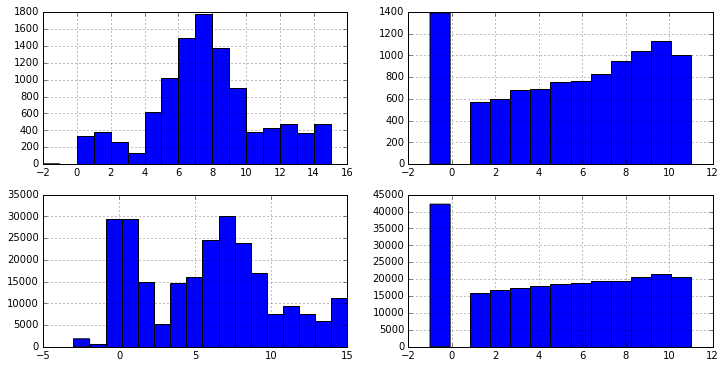

In [15]:
mask = X['diff'] > 0

plt.figure(figsize=(12,6))
plt.subplot(221)
X[mask]['age'].hist(bins=17)
plt.subplot(222)
X[mask]['renta'].hist(bins=13)
plt.subplot(223)
X['age'].hist(bins=17)
plt.subplot(224)
X['renta'].hist(bins=13)

Separate young people from other due to different train/val distributions

In [16]:
mask = X['age'].isin([0, 1, 2]) 
mask_clients = X[mask]['ncodpers']
X_1 = X[mask]
Y_1 = Y[mask]
X_0 = X[~mask]
Y_0 = Y[~mask]
mask = clients_last_choice['ncodpers'].isin(mask_clients)
clients_last_choice_1 = clients_last_choice[mask]
clients_last_choice_0 = clients_last_choice[~mask]

### Run KFold Cross-validation 

In [17]:
young_profiles = {
     0: ['renta', 'nomprov', 'ind_actividad_cliente', 'antiguedad'],
#      0: ['renta', 'nomprov', 'antiguedad'],    
#      1: ['pais_residencia', 'sexo', 'age', 'segmento', 'nomprov'],
#      2: ['pais_residencia', 'sexo', 'age', 'segmento', 'antiguedad'],
#      3: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_nuevo'],
#      4: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_actividad_cliente'],
#      5: ['pais_residencia', 'sexo', 'age', 'segmento', 'canal_entrada'],
#      6: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_nuevo', 'canal_entrada'],
#      7: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_empleado'],
     8: ['pais_residencia', 'sexo', 'age', 'segmento', 'renta'],
#      9: ['sexo', 'age', 'segmento'],    
#      10: ['sexo', 'age', 'segmento', 'ind_actividad_cliente']
#      11: ['nomprov', 'ind_nuevo', 'antiguedad', 'renta', 'ind_actividad_cliente', 'canal_entrada']
}

other_profiles = {
     0: ['pais_residencia', 'sexo', 'age', 'ind_nuevo', 'segmento', 'ind_empleado', 'ind_actividad_cliente', 'indresi'],
#      1: ['pais_residencia', 'sexo', 'age', 'segmento', 'nomprov'],
#      2: ['pais_residencia', 'sexo', 'age', 'segmento', 'antiguedad'],
#      3: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_nuevo'],
#      4: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_actividad_cliente'],
#      5: ['pais_residencia', 'sexo', 'age', 'segmento', 'canal_entrada'],
#      6: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_nuevo', 'canal_entrada'],
#      7: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_empleado'],
     8: ['pais_residencia', 'sexo', 'age', 'segmento', 'renta'],
#      9: ['sexo', 'age', 'segmento'],    
#      10: ['sexo', 'age', 'segmento', 'ind_actividad_cliente']
     11: ['nomprov', 'ind_nuevo', 'antiguedad', 'renta', 'ind_actividad_cliente', 'canal_entrada']
}

profiles = other_profiles

In [18]:
def create_model():
    ll = len(TARGET_LABELS)
    final_model = Sequential()
    models = []
    for key in profiles:
        length = len(profiles[key])
        model = Sequential()
        model.add(Dense(50, init='uniform', input_shape=(length,), activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(10 + length, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(ll, activation='sigmoid'))
        models.append(model)

    merged = Merge(models, mode='ave')
    final_model.add(merged)
    final_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return final_model

In [21]:
from sklearn.model_selection import KFold

nb_folds=5


def visualize_train_test(X_train, X_test, profile, Y_train=None, Y_test=None):
    plt.figure(figsize=(12,6))        
    ll = len(profile)
    if Y_train is not None and Y_test is not None:
        ll += 1
    
    for i, feature in enumerate(profile):
        plt.subplot(2,ll, i+1)
        plt.title("Train '%s' hist" % (feature))
        X_train[feature].hist()
        
        plt.subplot(2,ll, ll + i + 1)
        plt.title("Test '%s' hist" % (feature))
        X_test[feature].hist()

    if Y_train is not None and Y_test is not None:
        plt.subplot(2, ll, ll)
        plt.title("Train targets hist")
        Y_train[TARGET_LABELS].sum(axis=0).plot.bar()

        plt.subplot(2, ll, 2*ll)
        plt.title("Test targets hist")
        Y_test[TARGET_LABELS].sum(axis=0).plot.bar()
    

def visualize_folds(x_df, nb_folds, profile, y_df=None):
    kf = KFold(n_splits=nb_folds)
    for train_index, test_index in kf.split(range(x_df.shape[0])):
        X_train, X_val = x_df.loc[x_df.index[train_index], :], x_df.loc[x_df.index[test_index], :]
        if y_df is not None:
            Y_train, Y_val = y_df.loc[y_df.index[train_index], :], y_df.loc[y_df.index[test_index], :]            
        else:
            Y_train, Y_val = None, None
        mask = X_train['diff'] > 0
        visualize_train_test(X_train[mask], X_val, profile, Y_train[mask], Y_val)            

            
def max_map7_score_per_fold(x_df, y_df, clients_last_choice_df, nb_folds):    
    kf = KFold(n_splits=nb_folds)
    scores = []
    for train_index, test_index in kf.split(range(x_df.shape[0])):
        X_val = x_df.loc[x_df.index[test_index], :]
        Y_val = y_df.loc[y_df.index[test_index], :]
        CLC_val = clients_last_choice_df.loc[clients_last_choice_df.index[test_index], :]                
        x_val, y_val = prepare_to_test(X_val, Y_val)
        scores.append(map7_score2(y_val, y_val, CLC_val[TARGET_LABELS].values))  
    return scores
        
#visualize_folds(X_0, 5, other_profiles[0], Y_0)
#visualize_folds(X_1, 5, young_profiles[0], Y_1)
#max_map7_score_per_fold(X_1, Y_1, clients_last_choice, 5)

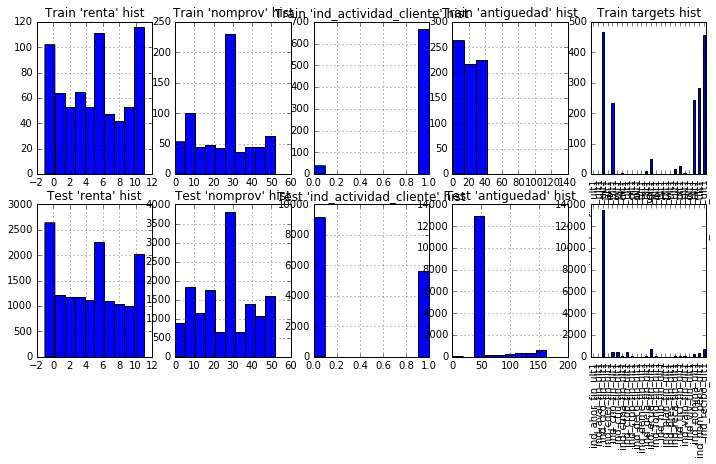

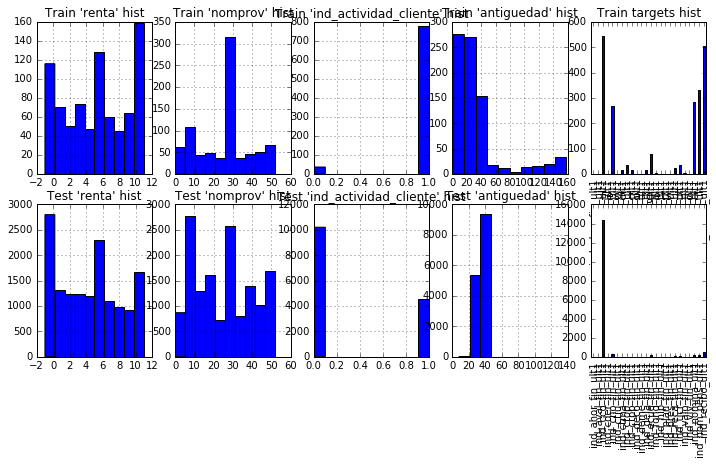

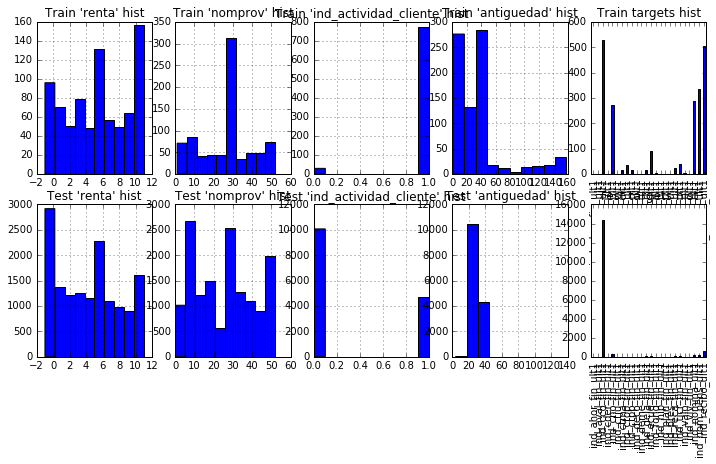

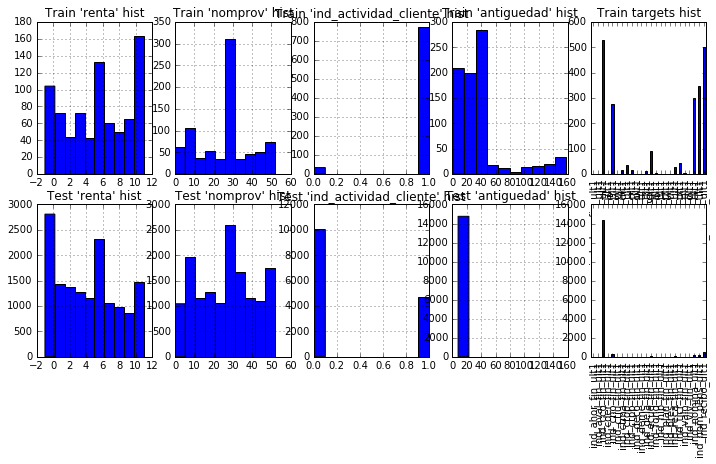

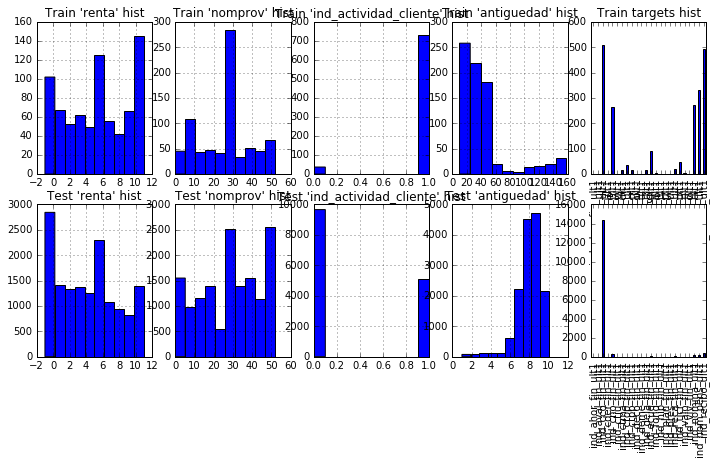

In [22]:
visualize_folds(X_1, 5, young_profiles[0], Y_1)

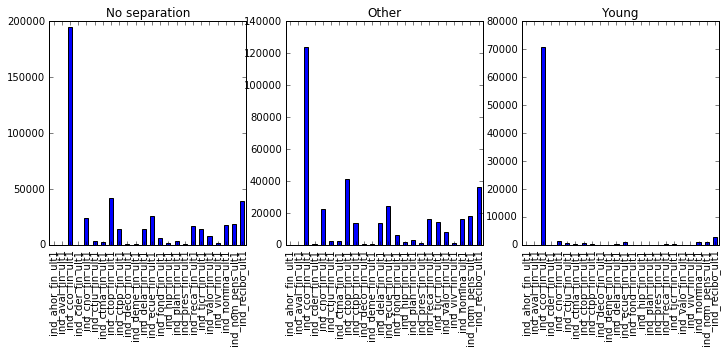

In [23]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title("No separation")
Y[TARGET_LABELS].sum(axis=0).plot.bar()
plt.subplot(132)
plt.title("Other")
Y_0[TARGET_LABELS].sum(axis=0).plot.bar()
plt.subplot(133)
plt.title("Young")
Y_1[TARGET_LABELS].sum(axis=0).plot.bar()

In [24]:
# CROSS VALIDATION
from sklearn.preprocessing import StandardScaler
n_highest = 7

# def dummies_to_decimal(row):
#     output = ''
#     for v in row.values:
#         output += str(int(v))
#     return log(int(output,2)+1)

def prepare_to_fit(X_train, Y_train):
    # Select only active client for the training part
    mask = X_train['diff'] > 0
    X_train_ = X_train[mask]
    y_train = Y_train[mask][TARGET_LABELS].values
    
    x_train = []
    for key in profiles:
        x_train_ = X_train_[profiles[key]].values
        x_train_ = StandardScaler().fit_transform(x_train_)
        x_train.append(x_train_)
    return x_train, y_train

def prepare_to_fit_nomask(X_train, Y_train):
    y_train = Y_train[TARGET_LABELS].values
    x_train = []
    for key in profiles:
        x_train_ = X_train[profiles[key]].values
        x_train_ = StandardScaler().fit_transform(x_train_)
        x_train.append(x_train_)
    return x_train, y_train

def prepare_to_test(X_val, Y_val=None):
    if Y_val is not None:
        y_val = Y_val[TARGET_LABELS].values
    
    x_val = []
    for key in profiles:
        x_val_ = X_val[profiles[key]].values    
        x_val_ = StandardScaler().fit_transform(x_val_)  
        x_val.append(x_val_)    
    
    if Y_val is not None:
        return x_val, y_val
    else:
        return x_val

def cross_val_score2(data, nb_folds=5, 
                     prepare_to_fit_func=prepare_to_fit, 
                     prepare_to_test_func=prepare_to_test, 
                     create_model_func=create_model):
    
    x_df, y_df, clients_last_choice_df = data
    kf = KFold(n_splits=nb_folds)
    scores = []
    
    for train_index, test_index in kf.split(range(x_df.shape[0])):
        X_train, X_val = x_df.loc[x_df.index[train_index], :], x_df.loc[x_df.index[test_index], :]
        Y_train, Y_val = y_df.loc[y_df.index[train_index], :], y_df.loc[y_df.index[test_index], :]
        CLC_val = clients_last_choice_df.loc[clients_last_choice_df.index[test_index], :]
                
        x_train, y_train = prepare_to_fit_func(X_train, Y_train)
        x_val, y_val = prepare_to_test_func(X_val, Y_val)
        
        logging.info("- Train/Val shapes : {}, {} | {}, {}".format(
                [i.shape for i in x_train] if isinstance(x_train, list) else x_train.shape, 
                [i.shape for i in x_val] if isinstance(x_val, list) else x_val.shape, 
                y_train.shape, 
                y_val.shape)
        )                
            
        logging.info("- Create the model")
        estimator = create_model_func()
        logging.info("- Fit the model")
        hist = estimator.fit(x_train, y_train, nb_epoch=150, batch_size=2000, verbose=0)        
        for key in hist.history:            
            logging.info("-- %s : min=%f, max=%f" % (key, np.min(hist.history[key]), np.max(hist.history[key])))
        
        logging.info("- Predict using trained model")
        y_pred = estimator.predict(x_val, verbose=0)
        logging.info("- Compute map7 score")
        scores.append(map7_score2(y_val, y_pred, CLC_val[TARGET_LABELS].values))        
    
    return np.array(scores)

In [ ]:
results = cross_val_score2((X_0, Y_0, clients_last_choice_0), nb_folds=nb_folds)
print "Cross-Validation \n %i | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), results.max(), results.std())

In [ ]:
results = cross_val_score2((X_1, Y_1, clients_last_choice_1), 
                           nb_folds=nb_folds, 
                           prepare_to_fit_func=prepare_to_fit,
                           prepare_to_test_func=prepare_to_test,                           
                           create_model_func=create_model
                          )
print "Cross-Validation \n %i | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), results.max(), results.std())

### Test 4 : Train on active clients + feature engineering

#### Data:

- yearmonth_list = [201505, 201506]
- nb_clients = 100000

#### Feature engineering

- age -> age group
- income -> income group
- separate young clients from others due to different train/test distributions


#### Model

- merged profiles with 'ave', sigmoid, binary_crossentropy, nadam, accuracy, 


**Conf:**
- batch_size=2000

*Cross-validation results :* 

On the others

type | profiles | Nb epoch | Nb folds | Min MAP@7 | Mean MAP@7 | Max MAP@7 | STD MAP@7
 --- | --- | --- | --- | --- | --- | --- | ---
other | other | 150 | 5 | 0.030910 | 0.040277 | 0.056534 | 0.01018 
other | young | 150 | 5 | 0.030285 | 0.038983 | 0.052295 | 0.00880
young | young | 150 | 5 | 0.011273 | 0.014734 | 0.021766 | 0.00387 




### Test 3 : Train on active clients

#### Data:

- yearmonth_list = [201505, 201506]
- nb_clients = max

#### Model

- merged profiles with 'ave', sigmoid, binary_crossentropy, nadam, accuracy, 


**Conf:**
- Profiles : 0, 1, 8
- batch_size=2000

*Cross-validation results :* 

Nb epoch | Nb folds | Min MAP@7 | Mean MAP@7 | Max MAP@7 | STD MAP@7
--- | --- | --- | --- | --- | ---
150 | 5 | 0.021769 | 0.030416 | 0.041625 | 0.00679 



#### Data:

- yearmonth_list = [201505, 201506]
- nb_clients = 100000

#### Model

- merged profiles with 'ave', sigmoid, binary_crossentropy, nadam, accuracy, 


**Conf:**
- Profiles : 0, 1, 8
- batch_size=1000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
150 | 5 | 0.030864 | 0.00731


**Conf:**
- Profiles : 0, 8 
- batch_size=500

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
150 | 5 | 0.030895 | 0.00732
500 | 5 | 0.030959 | 0.00776


**Conf:**
- Profiles : 0, 8 
- batch_size=1000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
150 | 5 | 0.030885 | 0.00758
500 | 5 | 0.030639 | 0.00769



In [ ]:
## young_profile = ['pais_residencia', 'sexo', 'nomprov', 'renta', 'ind_actividad_cliente', 'canal_entrada']
# young_profile = ['renta', 'nomprov', 'ind_actividad_cliente']

# def prepare_to_fit2(X_train, Y_train):
#     # Select only active client for the training part
#     mask = X_train['diff'] > 0
#     X_train_ = X_train[mask]
#     y_train = Y_train[mask][TARGET_LABELS].values    
    
#     x_train = X_train_[young_profile].values
#     x_train = StandardScaler().fit_transform(x_train)
#     return x_train, y_train

# def prepare_to_fit3(X_train, Y_train):
#     X_train_ = X_train
#     y_train = Y_train[TARGET_LABELS].values    
    
#     x_train = X_train_[young_profile].values
#     x_train = StandardScaler().fit_transform(x_train)
#     return x_train, y_train


# def prepare_to_test2(X_val, Y_val=None):
#     if Y_val is not None:
#         y_val = Y_val[TARGET_LABELS].values
    
#     x_val = X_val[young_profile].values    
#     x_val = StandardScaler().fit_transform(x_val)  
    
#     if Y_val is not None:
#         return x_val, y_val
#     else:
#         return x_val


# def create_model2():
#     ll = len(TARGET_LABELS)
#     length = len(young_profile)
#     final_model = Sequential()
#     final_model.add(Dense(50, init='uniform', input_shape=(length,), activation='relu'))
#     final_model.add(Dropout(0.15))
#     final_model.add(Dense(40, activation='relu'))
#     final_model.add(Dropout(0.15))
#     final_model.add(Dense(20, activation='relu'))
#     final_model.add(Dropout(0.15))
#     final_model.add(Dense(ll, activation='sigmoid'))    
#     final_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
#     return final_model

## Train model for predictions

In [ ]:
def train_model(X_train, Y_train):

    x_train, y_train = prepare_to_fit(X_train, Y_train)
    logging.info("- Train data shapes : {}, {}".format(
            [i.shape for i in x_train], 
            y_train.shape)
    )                

    logging.info("- Create the model")
    estimator = create_model()
    logging.info("- Fit the model")
    hist = estimator.fit(x_train, y_train, nb_epoch=150, batch_size=1000, verbose=0)        
    for key in hist.history:            
        logging.info("-- %s : min=%f, max=%f" % (key, np.min(hist.history[key]), np.max(hist.history[key])))
    return estimator

estimator = train_model(X, Y)

Check score on the same data

In [ ]:
x_val, y_val = prepare_to_test(X, Y)
y_pred = estimator.predict(x_val, verbose=0)

print "Score on the whole dataset : ", map7_score2(y_val, y_pred, clients_last_choice[TARGET_LABELS].values)


## Prediction on test data

In [ ]:
#del X, Y, X_train, X_val, Y_train, Y_val, trainval_df, data_df

Load the last month from the training dataset to get user last choice and remove it from predictions

In [17]:
from collections import defaultdict

encoder = defaultdict(dict)

cols = ['country']

train = ['a', 'a', 'b', 'c', 'a', 'd', 'b']
test = ['b', 'e', 'b', 'f', 'a']

_train_df = pd.DataFrame({cols[0]: train})
_test_df = pd.DataFrame({cols[0]: test})


def encode(encoder, df):
    print "-- Call encode --"
    string_data = df.select_dtypes(include=["object"])
    for c in string_data.columns:
        unique_vals = df[c].unique()
        # initialize :
        if len(encoder[c]) == 0 :
            print "- Initialize : ", c
            # fit :
            for i, v in enumerate(unique_vals):
                print "-1 Add : ", v, "->", i
                encoder[c][v] = i
        
        # check :
        isin_mask = np.in1d(unique_vals, encoder[c].keys())
        print "- Check :", c
        print "-- isin_mask: ", isin_mask.all()
        if not isin_mask.all():
            print "- Check is failed : need to add more"
            next_val = np.max(encoder[c].values()) + 1
            print "-- next_val: ", next_val
            # fit :
            for i, v in enumerate(unique_vals[~isin_mask]):                
                print "-2 Add : ", v, "->", next_val + i                    
                encoder[c][v] = next_val + i                
        
        # transform :
        print "- Transform : ", c
        df.loc[:, c] = df[c].apply(lambda x: encoder[c][x])

        
encode(encoder, _train_df)
print encoder
print _train_df

encode(encoder, _test_df)
print encoder
print _test_df



-- Call encode --
- Initialize :  country
-1 Add :  a -> 0
-1 Add :  b -> 1
-1 Add :  c -> 2
-1 Add :  d -> 3
isin_mask:  True
- Transform :  country
defaultdict(<type 'dict'>, {'country': {'a': 0, 'c': 2, 'b': 1, 'd': 3}})
   country
0        0
1        0
2        1
3        2
4        0
5        3
6        1
-- Call encode --
isin_mask:  False
- Check is failed : need to add more
-- max_val:  4
-2 Add :  e -> 4
-2 Add :  f -> 5
- Transform :  country
defaultdict(<type 'dict'>, {'country': {'a': 0, 'c': 2, 'b': 1, 'e': 4, 'd': 3, 'f': 5}})
   country
0        1
1        4
2        1
3        5
4        0


In [16]:
data_df = load_data2(TRAIN_FILE_PATH, yearmonth_list, nb_clients)
minimal_clean_data_inplace(data_df)


INFO:root:-- Select 250000 clients
INFO:root:- Number of lines with unknown data : 1514
INFO:root:- Number of columns with nan : 9


In [6]:
test_df = load_data2(TEST_FILE_PATH, [])
minimal_clean_data_inplace(test_df)


INFO:root:-- Read all data from the file : ../data/test_ver2.csv
INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10


In [25]:
data_df['ind_nuevo'] = data_df['ind_nuevo'].astype(int)
test_df['ind_nuevo'] = test_df['ind_nuevo'].astype(int)
data_df['ind_nuevo'].unique(), test_df['ind_nuevo'].unique(), 

(array([0, 1]), array([0, 1]))

In [18]:
encoder = defaultdict(dict)

_train_df = data_df.drop(['fecha_dato', 'fecha_alta'], axis=1)
_test_df = test_df.drop(['fecha_dato', 'fecha_alta'], axis=1)

encode(encoder, _train_df)



-- Call encode --
- Initialize :  ind_empleado
-1 Add :  N -> 0
-1 Add :  A -> 1
-1 Add :  B -> 2
-1 Add :  F -> 3
isin_mask:  True
- Transform :  ind_empleado
- Initialize :  pais_residencia
-1 Add :  ES -> 0
-1 Add :  AT -> 1
-1 Add :  IE -> 2
-1 Add :  GB -> 3
-1 Add :  FR -> 4
-1 Add :  BE -> 5
-1 Add :  VE -> 6
-1 Add :  DE -> 7
-1 Add :  CH -> 8
-1 Add :  BR -> 9
-1 Add :  MX -> 10
-1 Add :  CO -> 11
-1 Add :  PT -> 12
-1 Add :  HN -> 13
-1 Add :  IT -> 14
-1 Add :  PE -> 15
-1 Add :  MA -> 16
-1 Add :  SE -> 17
-1 Add :  MZ -> 18
-1 Add :  DO -> 19
-1 Add :  CN -> 20
-1 Add :  US -> 21
-1 Add :  GR -> 22
-1 Add :  NL -> 23
-1 Add :  FI -> 24
-1 Add :  RO -> 25
-1 Add :  AR -> 26
-1 Add :  UA -> 27
-1 Add :  GT -> 28
-1 Add :  PL -> 29
-1 Add :  SN -> 30
-1 Add :  CL -> 31
-1 Add :  SV -> 32
-1 Add :  NI -> 33
-1 Add :  RU -> 34
-1 Add :  IL -> 35
-1 Add :  HR -> 36
-1 Add :  EC -> 37
-1 Add :  HK -> 38
-1 Add :  BG -> 39
-1 Add :  CU -> 40
-1 Add :  NG -> 41
-1 Add :  JP -> 42
-

In [20]:
encode(encoder, _test_df)

-- Call encode --
isin_mask:  False
- Check is failed : need to add more
-- max_val:  4
-2 Add :  S -> 4
- Transform :  ind_empleado
isin_mask:  False
- Check is failed : need to add more
-- max_val:  93
-2 Add :  DJ -> 93
-2 Add :  QA -> 94
-2 Add :  MR -> 95
-2 Add :  ET -> 96
-2 Add :  JM -> 97
-2 Add :  TG -> 98
-2 Add :  TN -> 99
-2 Add :  LB -> 100
-2 Add :  BA -> 101
-2 Add :  IS -> 102
-2 Add :  TW -> 103
-2 Add :  CR -> 104
-2 Add :  MT -> 105
-2 Add :  GH -> 106
-2 Add :  OM -> 107
-2 Add :  GI -> 108
-2 Add :  MM -> 109
-2 Add :  BM -> 110
-2 Add :  AL -> 111
-2 Add :  ZW -> 112
-2 Add :  CF -> 113
-2 Add :  GM -> 114
-2 Add :  CD -> 115
-2 Add :  KZ -> 116
-2 Add :  GW -> 117
- Transform :  pais_residencia
isin_mask:  False
- Check is failed : need to add more
-- max_val:  2
-2 Add :  UNKNOWN -> 2
- Transform :  sexo
isin_mask:  False
- Check is failed : need to add more
-- max_val:  2
-2 Add :  0 -> 2
-2 Add :  1 -> 3
- Transform :  ind_nuevo
isin_mask:  False
- Check is f

In [25]:
yearmonth_list = [201605]
lastmonth_df = load_data2(TRAIN_FILE_PATH, yearmonth_list)
minimal_clean_data_inplace(lastmonth_df)

test_df = load_data2(TEST_FILE_PATH, [])
minimal_clean_data_inplace(test_df)
preprocess_data_inplace(test_df)
test_df = test_df.sort_values(['ncodpers'])

clients_last_choice_test = lastmonth_df[['ncodpers'] + TARGET_LABELS].sort_values(['ncodpers'])
# Select only clients from test data
clients_last_choice_test = clients_last_choice_test[clients_last_choice_test['ncodpers'].isin(test_df['ncodpers'])]
assert (test_df['ncodpers'] == clients_last_choice_test['ncodpers']).all(), "WTF"

INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10
INFO:root:-- Read all data from the file : ../data/test_ver2.csv
INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10


ValueError: y contains new labels: ['AL' 'BM' 'BZ' 'CD' 'CF' 'CG' 'DJ' 'GI' 'GM' 'GN' 'GW' 'HU' 'JM' 'KH' 'KW'
 'KZ' 'LB' 'LV' 'ML' 'MR' 'MT' 'QA' 'RS' 'SL' 'TN' 'ZW']

In [ ]:
X_test = test_df[['ncodpers'] + features]

In [ ]:
X_test.loc[:,'age'] = X_test['age'].apply(get_age_group_index)
X_test.loc[:,'renta'] = X_test['renta'].apply(get_income_group_index)

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
X_test['age'].hist(bins=17)
plt.subplot(122)
X_test['renta'].hist(bins=13)

In [ ]:
visualize_train_test(X, X_test, young_profiles[0])

Separate young people from others 

In [ ]:
mask = X_test['age'].isin([0, 1, 2]) 
mask_clients = X_test[mask]['ncodpers']
X_test_1 = X_test[mask]
X_test_0 = X_test[~mask]
mask = clients_last_choice_test['ncodpers'].isin(mask_clients)
clients_last_choice_test_1 = clients_last_choice_test[mask]
clients_last_choice_test_0 = clients_last_choice_test[~mask]

In [ ]:
visualize_train_test(X_0, X_test_0, np.array(other_profiles[0])[[0,5]])

In [ ]:
visualize_train_test(X_1, X_test_1, young_profiles[0])

Make predictions

In [ ]:
x_test = prepare_to_test(X_test)
y_pred = estimator.predict(x_test, verbose=0)

def get_submission(y_pred, clients, clc, target_labels, n_highest=7):
    predicted_added_products = np.argsort(y_pred, axis=1)
    predicted_added_products = predicted_added_products[:,::-1][:,:n_highest]
    added_products_col = []
    count = 0 
    for products, last_choice in zip(predicted_added_products, clc):
        predictions = remove_last_choice(products, last_choice)
        added_products_col.append(' '.join([target_labels[i] for i in predictions]))
        count+=1
        if count % 100000 == 0:
            logging.info("Elapsed : %i", count)
            
    out = pd.DataFrame(data={'ncodpers': clients, 'added_products': added_products_col}, columns=['ncodpers', 'added_products'])
    return out


clients = X_test['ncodpers']
submission = get_submission(y_pred, clients, clients_last_choice_test[TARGET_LABELS].values, TARGET_LABELS, 7)
submission.head()

In [ ]:
# Add missing young clients from X_test_1
# clients = X_test_1['ncodpers']
# added_products_col = [''] * len(clients)
# p2 = pd.DataFrame(data={'ncodpers': clients, 'added_products': added_products_col}, columns=['ncodpers', 'added_products'])
# submission = pd.concat([submission, p2])

Get submission DataFrame and write csv file

In [ ]:
from datetime import datetime
import csv

logging.info('- Generate submission')
submission_file = '../results/submission_' + \
                  str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + \
                  '.csv'

submission.to_csv(submission_file, index=False, index_label=False)